In [1]:
# | echo: false

import math

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

plt.rcParams['font.sans-serif'] = ['Source Han Serif']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
sns.set(font='Lantinghei SC')


# 哈尔滨工业大学（深圳）《统计机器学习》2023 春 实验五

## 预处理

本次需要处理的原始数据均为连续量，直接读入即可。


In [2]:
# | label: tbl-raw
# | tbl-cap: 原始数据

df = pd.read_excel("实验五资料/农村居民人均可支配收入来源2016.xlsx")
df

,地区,工资性收入,经营净收入,财产净收入,转移净收入
0,北京,16637.5,2061.9,1350.1,2260.0
1,天津,12048.1,5309.4,893.7,1824.4
2,河北,6263.2,3970.0,257.5,1428.6
3,山西,5204.4,2729.9,149.0,1999.1
4,内蒙古,2448.9,6215.7,452.6,2491.7
5,辽宁,5071.2,5635.5,257.6,1916.4
6,吉林,2363.1,7558.9,231.8,1969.1
7,黑龙江,2430.5,6425.9,572.7,2402.6
8,上海,18947.9,1387.9,859.6,4325.0
9,江苏,8731.7,5283.1,606.0,2984.8


为了消除不同量级的影响，我们在进行聚类之前需要先进行标准化，此处使用 `sklearn` 中的 `StandardScaler` 完成 z-score 标准化。

In [3]:
from sklearn.preprocessing import StandardScaler

coord_cols = df.columns[1:]
coord = np.array(df[coord_cols])
scaler = StandardScaler()
standard_coord = scaler.fit_transform(coord)

下面这个函数会初始化用于记录模型评价分数的表。

In [4]:
from sklearn.metrics import silhouette_score

score_col_k = "聚类数目"
score_col_sse = "簇内误差平方和"
score_col_silhouette_score = "轮廓系数"
score_col_type = "类型"


def make_score_df():
    return pd.DataFrame(
        {
            score_col_k: [],
            score_col_sse: [],
            score_col_silhouette_score: [],
            score_col_type: [],
        }
    )

## K-均值聚类

需要注意到聚类的坐标是标准化后的坐标，利用返回的质心前要先将其进行标准化的逆变换。

还要考虑到质心更新的时候可能会导致聚到同一类导致失败，此处实现为直接在检测到只剩一类时退出重试。

经试验，k > 8 时经常会出现失败的情况，因此此处选择仅测试 8 以下的情况。


In [5]:
def k_means(coord, class_count, retry_limit=100):
    gen = np.random.Generator(np.random.PCG64())
    for _ in range(retry_limit):
        centers = gen.normal(0, 1, (class_count, coord.shape[1]))

        length = coord.shape[0]
        classification = np.zeros(length, dtype=int)

        while True:
            old_classification = classification.copy()

            for i in range(length):
                dist_to_classes = np.linalg.norm(centers - coord[i], axis=1)
                classification[i] = np.argmin(dist_to_classes)

            current_classes, current_classes_counts = np.unique(
                classification, return_counts=True
            )
            if len(current_classes) <= 1:
                # print("所有点已被归为同类，算法执行失败！")
                break

            if not np.any(classification != old_classification):
                if len(current_classes) < class_count:
                    # print(f"类别已经不会再变化，但只有 {len(current_classes)}<{class_count} 个有点的类别，算法执行失败！")
                    break
                current_classes_sorted = current_classes[
                    np.argsort(current_classes_counts)
                ]
                for i, indices in enumerate(
                    [classification == cls for cls in current_classes_sorted]
                ):
                    classification[indices] = i
                return classification, centers[current_classes_sorted]

            # 更新质心，跳过暂时没有点的
            for cls in current_classes:
                centers[cls] = np.mean(coord[classification == cls], axis=0)
    raise RuntimeError(f"聚类数目目标 {class_count} 已连续失败 {retry_limit} 次，放弃了")


k_means_score = make_score_df()

for k in range(2, 9):
    for _ in range(100):
        result, standard_centers = k_means(standard_coord, k)
        k_means_centers = scaler.inverse_transform(standard_centers)

        sse = 0
        for cls in np.unique(result):
            coord_of_cls = coord[result == cls]
            sse += np.sum((coord_of_cls - k_means_centers[cls]) ** 2)
        k_means_score.loc[len(k_means_score.index)] = [
            k,
            sse,
            silhouette_score(coord, result),
            "K-均值聚类",
        ]
    print(f"完成 k={k} 时的模型评价")

完成 k=2 时的模型评价
完成 k=3 时的模型评价
完成 k=4 时的模型评价
完成 k=5 时的模型评价
完成 k=6 时的模型评价
完成 k=7 时的模型评价
完成 k=8 时的模型评价


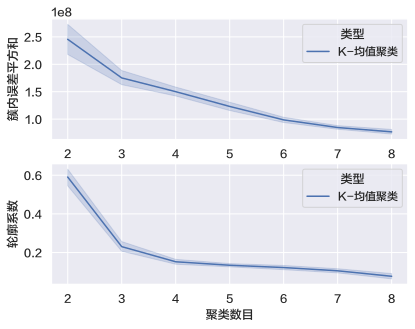

In [31]:
# | label: fig-lineplot-k-means
# | fig-cap: K-均值聚类的簇内误差平方和-聚类数目图与轮廓系数-聚类数目图

fig, (ax1, ax2) = plt.subplots(2, 1)
sns.lineplot(
    k_means_score,
    x=score_col_k,
    y=score_col_sse,
    hue=score_col_type,
    markers=True,
    ax=ax1,
)
sns.lineplot(
    k_means_score,
    x=score_col_k,
    y=score_col_silhouette_score,
    hue=score_col_type,
    markers=True,
    ax=ax2,
)
plt.show()

经观察可知，k = 6 是一个较为合适的值，下面以此进行一次聚类来展示，将质心作为有特殊分类的样本点加入 `DataFrame` 并用 Seaborn 绘制，
我们希望用相似的颜色来标记类中的点与质心，这可以通过 Matplotlib 的两个特殊[调色板](https://matplotlib.org/stable/tutorials/colors/colormaps.html) `tab10` 与 `tab20` 来实现。为此，我们需要对作为 Seaborn Hue 的值进行一些映射。下图中颜色较深的是质心。

In [34]:
# | label: tbl-k-means-result
# | tbl-cap: K-均值聚类的结果（k=6）

df_with_center = df.copy(deep=True)
result, standard_centers = k_means(standard_coord, 6)
k_means_centers = scaler.inverse_transform(standard_centers)
df_with_center["分类"] = result * 2 + 1
# sns.pairplot(df_with_center.drop(['地区'], axis=1), hue="分类", palette="tab10")
for i, center in enumerate(k_means_centers):
    df_with_center.loc[len(df_with_center.index)] = [f"第{i}类中心", *center, i * 2]
df_with_center.sort_values("分类")

,地区,工资性收入,经营净收入,财产净收入,转移净收入,分类
31,第0类中心,13126.200000,5465.650000,777.750000,2101.250000,0
1,天津,12048.100000,5309.400000,893.700000,1824.400000,1
10,浙江,14204.300000,5621.900000,661.800000,2378.100000,1
32,第1类中心,17792.700000,1724.900000,1104.850000,3292.500000,2
0,北京,16637.500000,2061.900000,1350.100000,2260.000000,3
8,上海,18947.900000,1387.900000,859.600000,4325.000000,3
33,第2类中心,2414.166667,6733.500000,419.033333,2287.800000,4
4,内蒙古,2448.900000,6215.700000,452.600000,2491.700000,5
6,吉林,2363.100000,7558.900000,231.800000,1969.100000,5
7,黑龙江,2430.500000,6425.900000,572.700000,2402.600000,5


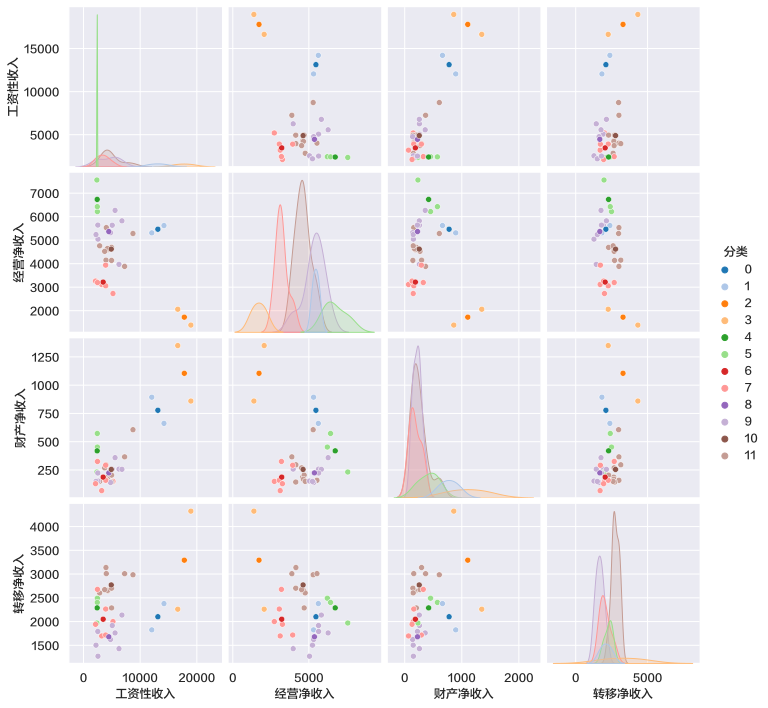

In [35]:
# | label: fig-pairplot-k-means
# | fig-cap: K-均值聚类下属性两两配对的散点图（k=6）

sns.pairplot(df_with_center.drop(["地区"], axis=1), hue="分类", palette="tab20")

下面使用 TSNE 进行降维并可视化。

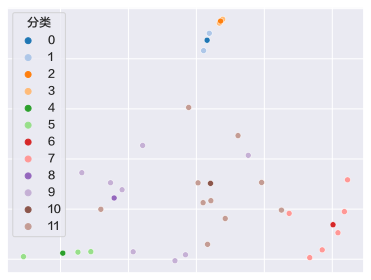

In [36]:
# | label: fig-tsne-k-means
# | fig-cap: K-均值聚类的 TSNE 可视化（k=6）

from sklearn.manifold import TSNE

tsne = TSNE()
tsne_df = pd.DataFrame(
    tsne.fit_transform(df_with_center.drop(["地区", "分类"], axis=1)),
    index=df_with_center.index,
)
tsne_df["分类"] = df_with_center["分类"]
tsne_plot = sns.scatterplot(tsne_df, x=0, y=1, hue="分类", palette="tab20")
tsne_plot.set(xlabel=None, xticklabels=[], ylabel=None, yticklabels=[])
None

## 聚合聚类

由聚合聚类本身特性，多次重复聚类会得到完全相同的结果，因此此处对于每个 k 值只进行一次测试。


In [33]:
def merge_clustering(coord, class_count_target):
    length = coord.shape[0]
    classification = np.indices((length,)).flatten()

    while True:
        alive_classes = np.unique(classification)
        class_count = len(alive_classes)
        # print(alive_classes)
        if class_count <= class_count_target:
            return classification

        meanses = np.zeros((class_count, coord.shape[1]))
        for i in range(class_count):
            meanses[i] = np.mean(coord[classification == alive_classes[i]], axis=0)

        dist_mat = np.full((class_count, class_count), np.inf)
        for i in range(class_count):
            for j in range(i):
                dist_mat[i, j] = np.linalg.norm(meanses[i] - meanses[j])

        a, b = np.unravel_index(np.argmin(dist_mat), dist_mat.shape)
        class_a = alive_classes[a]
        class_b = alive_classes[b]
        # print(class_a, "merge to", class_b)
        classification[classification == class_a] = class_b


mc_score = make_score_df()

for k in range(2, 11):
    mc_classification = merge_clustering(standard_coord, k)

    sse = 0
    for cls in np.unique(mc_classification):
        coord_of_cls = coord[mc_classification == cls]
        sse += np.sum(np.var(coord_of_cls, axis=0)) * len(coord_of_cls)
    mc_score.loc[len(mc_score.index)] = [
        k,
        sse,
        silhouette_score(coord, mc_classification),
        "聚合聚类",
    ]
    print(f"完成 k={k} 时的模型评价")

完成 k=2 时的模型评价
完成 k=3 时的模型评价
完成 k=4 时的模型评价
完成 k=5 时的模型评价
完成 k=6 时的模型评价
完成 k=7 时的模型评价
完成 k=8 时的模型评价
完成 k=9 时的模型评价
完成 k=10 时的模型评价


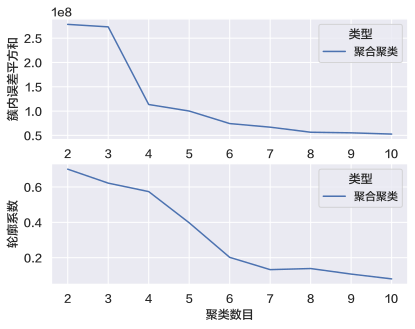

In [30]:
# | label: fig-lineplot-mc
# | fig-cap: 聚合聚类的簇内误差平方和-聚类数目图与轮廓系数-聚类数目图

fig, (ax1, ax2) = plt.subplots(2, 1)
sns.lineplot(
    mc_score,
    x=score_col_k,
    y=score_col_sse,
    hue=score_col_type,
    markers=True,
    ax=ax1
)
sns.lineplot(
    mc_score,
    x=score_col_k,
    y=score_col_silhouette_score,
    hue=score_col_type,
    markers=True,
    ax=ax2,
)
plt.show()

可以看出，在 k = 4 时 SSE 存在一个肘部，而此时轮廓系数依然较高。以此进行聚类。

In [18]:
# | label: tbl-mc-result
# | tbl-cap: 聚合聚类的结果（k=4）

mc_df = df.copy(deep=True)
mc_classification = merge_clustering(standard_coord, 4)
mc_df["分类"] = mc_classification * 2 + 1
mc_df.sort_values("分类")

,地区,工资性收入,经营净收入,财产净收入,转移净收入,分类
0,北京,16637.5,2061.9,1350.1,2260.0,1
1,天津,12048.1,5309.4,893.7,1824.4,3
9,江苏,8731.7,5283.1,606.0,2984.8,3
10,浙江,14204.3,5621.9,661.8,2378.1,3
28,青海,2464.3,3197.0,325.2,2677.8,5
27,甘肃,2125.0,3261.4,128.4,1942.0,5
26,陕西,3916.0,3057.9,159.0,2263.6,5
25,西藏,2204.9,5237.9,148.7,1502.3,5
24,云南,2553.9,5043.7,152.2,1270.1,5
23,贵州,3211.0,3115.8,67.1,1696.3,5


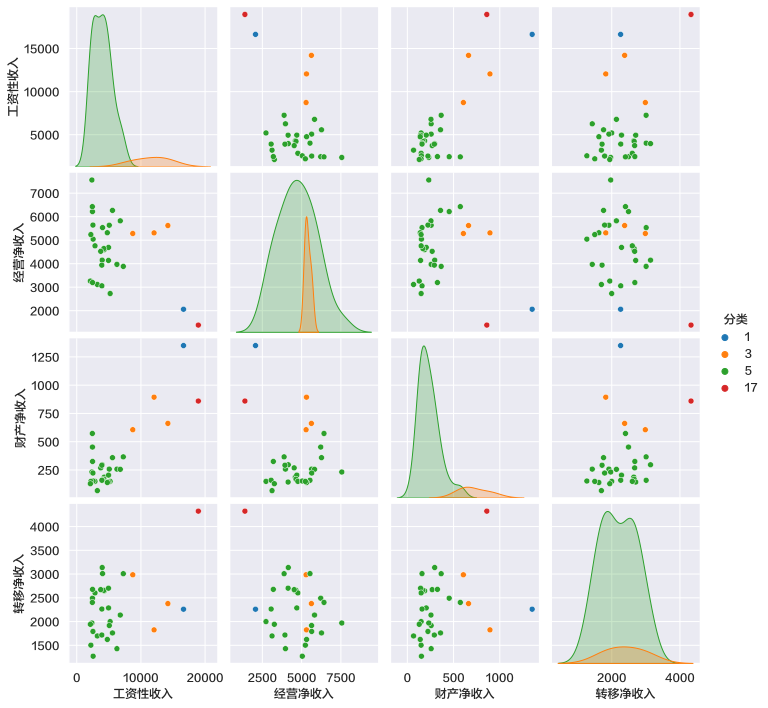

In [19]:
# | label: fig-pairplot-mc
# | fig-cap: 聚合聚类下属性两两配对的散点图（k=4）

sns.pairplot(mc_df.drop(["地区"], axis=1), hue="分类", palette="tab10")

下面同样使用 TSNE 进行可视化。

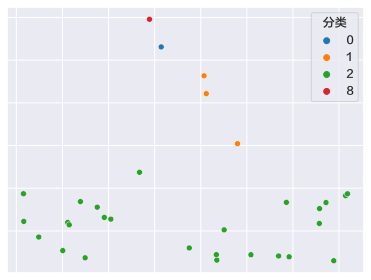

In [20]:
# | label: fig-tsne-mc
# | fig-cap: 聚合聚类的 TSNE 可视化（k=4）

from sklearn.manifold import TSNE

tsne = TSNE()
tsne.fit_transform(mc_df.drop(["地区", "分类"], axis=1))
tsne_df = pd.DataFrame(tsne.embedding_, index=df.index)
tsne_df["分类"] = mc_classification
tsne_plot = sns.scatterplot(tsne_df, x=0, y=1, hue="分类", palette="tab10")
tsne_plot.set(xlabel=None, xticklabels=[], ylabel=None, yticklabels=[])
None

## 模型对比

将两种模型的指标图像叠加。

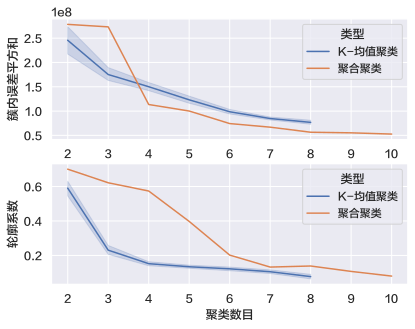

In [32]:
# | label: fig-lineplot-total
# | fig-cap: 两种聚类方法的簇内误差平方和-聚类数目图与轮廓系数-聚类数目图

merged_score = pd.concat([k_means_score, mc_score])

fig, (ax1, ax2) = plt.subplots(2, 1)
sns.lineplot(
    merged_score,
    x=score_col_k,
    y=score_col_sse,
    hue=score_col_type,
    markers=True,
    ax=ax1,
)
sns.lineplot(
    merged_score,
    x=score_col_k,
    y=score_col_silhouette_score,
    hue=score_col_type,
    markers=True,
    ax=ax2,
)
plt.show()

观察可知，k > 4 时聚合聚类的评价效果更好，SSE 更低，轮廓系数更高。